In [2]:
#Create transferfunction!
def transferfunction(freq): #Where B is given, NOT H!
    if freq<=0:
        raise Exception('Frequency cannot be any lower or equal to zero!')
       
    mu=4*np.pi*10**(-7)
    # conductivity parameters
    cond=np.zeros((2,4))
    cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
    cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m

    #first do bottom layer
    kn=np.sqrt(1j*freq*mu*cond[0,-1])
    Zn=1j*freq/kn

    # iterate from bottom to top
    for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
        kn=np.sqrt(1j*freq*mu*cond[0,-item])
        rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
        Zn=1j*freq*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

    return Zn

In [3]:
######################## writing results ###########################################
def writing_electric(thread,path,Electric,begin,end,lon,lat):
    for localvar.item in range(begin,end):
        logging.info(f'Thread {thread} is writing step {localvar.item}.')
        localvar.newfile=pd.DataFrame(columns=['lon','lat','value'])
        localvar.newfile.at[:,'lon']=lon
        localvar.newfile.at[:,'lat']=lat
        localvar.newfile.at[:,'value']=Electric[localvar.item,:]

        if localvar.item<10:
            localvar.newfile.to_csv(path_or_buf=f'{path}/electric_000{localvar.item}.csv', sep=' ', index=False, header=False)
        if localvar.item<100 and localvar.item>9:
            localvar.newfile.to_csv(path_or_buf=f'{path}/electric_00{localvar.item}.csv', sep=' ', index=False, header=False)
        if localvar.item<1000 and localvar.item>99:
            localvar.newfile.to_csv(path_or_buf=f'{path}/electric_0{localvar.item}.csv', sep=' ', index=False, header=False)
        if localvar.item>999:
            localvar.newfile.to_csv(path_or_buf=f'{path}/electric_{localvar.item}.csv', sep=' ', index=False, header=False)
        

hello
hello
hello
hi, we are still working!
elapsed time for reading files is 24.12741299599999 seconds
elapsed time for calculating fourier transform is 0.0004385929999983773 seconds
elapsed time for applying transferfunction is 0.04205117100001132 seconds
elapsed time for backward fourier transforming is 0.00021670499999970616 seconds


[]

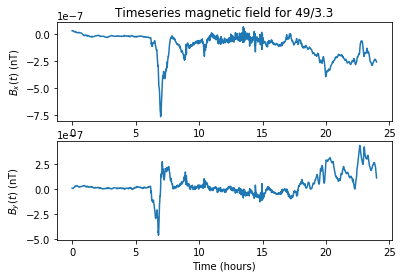

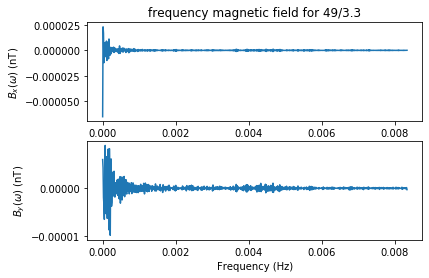

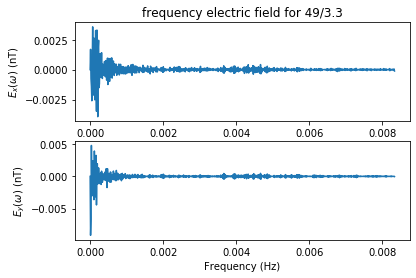

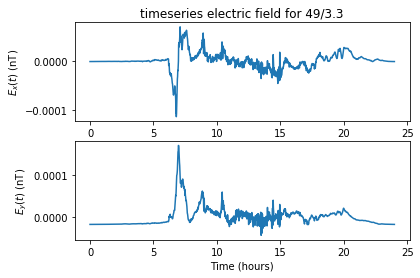

In [6]:
import scipy.signal.windows as spsw
import numpy as np
import os
from multiprocessing import Process
import pandas as pd
from time import process_time
from threading import local
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
localvar=local()
path='/usr/people/out/Documents/Magnetic_field/station_results/new_29-10-2003'

# import magnetic field data in X/Y-direction (north)
magnetic_Xfiles=[]
magnetic_Yfiles=[]

############################# get the strings ###################################
os.system(f"ls {path}/interpolation/minute_????.csv > {path}/tempX.txt")
os.system(f"ls {path}/interpolation/minute_????.csv.Y > {path}/tempY.txt")
f=open(f'{path}/tempX.txt')
for item in f:
    item=item.strip('\n')
    magnetic_Xfiles.append(item)
f.close()
os.system(f'rm {path}/tempX.txt')
f=open(f'{path}/tempY.txt')
for item in f:
    item=item.strip('\n')
    magnetic_Yfiles.append(item)
f.close()
os.system(f'rm {path}/tempY.txt')
   
magnetic_Xfiles=sorted(magnetic_Xfiles) #sort to number 0000-1440
magnetic_Yfiles=sorted(magnetic_Yfiles)

for file in magnetic_Xfiles:
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    break
for file in magnetic_Yfiles:
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    break
print('hello')
lat=np.zeros(len(Xfile))
lon=np.zeros(len(Xfile))
MX_matrix=np.zeros(len(magnetic_Xfiles)) #matrix for storing values (vertical same place, horizontal same time)
print('hello')
MXft_matrix=np.zeros(int(len(magnetic_Xfiles)/2)+1,dtype='complex')
print('hello')
EX_matrix=np.zeros(len(magnetic_Yfiles))
EXft_matrix=np.zeros(int(len(magnetic_Xfiles)/2)+1,dtype='complex')
MY_matrix=np.zeros(len(magnetic_Yfiles)) #matrix for storing values (vertical same place, horizontal same time)
MYft_matrix=np.zeros(int(len(magnetic_Xfiles)/2)+1,dtype='complex')
EY_matrix=np.zeros(len(magnetic_Xfiles)) 
EYft_matrix=np.zeros(int(len(magnetic_Xfiles)/2)+1,dtype='complex')
################################################################################# 
########################### get the values ######################################
######################### first x-direction #####################################
print('hi, we are still working!')
t1_start=process_time()
for counter,file in enumerate(magnetic_Xfiles):
    Xfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Xfile.to_numpy()
    MX_matrix[counter]=values[0,2]/(10**9)

lat=values[:,1]
lon=values[:,0]
for counter,file in enumerate(magnetic_Yfiles):
    Yfile=pd.read_csv(file, delimiter=' ', header=None)
    values=Yfile.to_numpy()
    MY_matrix[counter]=values[0,2]/(10**9)

t1_end=process_time()
print(f'elapsed time for reading files is {t1_end-t1_start} seconds')

Time=np.arange(0,24,24/1440.)
fig1=plt.figure()
ax11=fig1.add_subplot(211)
ax12=fig1.add_subplot(212)
ax11.set_title('Timeseries magnetic field for 49/3.3')
ax11.set_ylabel('$B_x(t)$ (nT)')
ax12.set_ylabel('$B_y(t)$ (nT)')
ax12.set_xlabel('Time (hours)')
ax11.plot(Time, MX_matrix)
ax12.plot(Time, MY_matrix)
plt.plot()

############## start fourier transformation ######################
t2_start=process_time()
for column in range(1):
    MXft_matrix[:]=np.fft.rfft(MX_matrix[:]*spsw.hann(len(MX_matrix))) #multiply with hanning window to reduce edge effects
for column in range(1):
    MYft_matrix[:]=np.fft.rfft(MY_matrix[:]*spsw.hann(len(MY_matrix)))
    # use rfft to only retain positive frequencies
    
t2_end=process_time()
print(f'elapsed time for calculating fourier transform is {t2_end-t2_start} seconds')
                   
# make frequencyvector in seconds
df=1./(24*60*60.) # seconds!
fmax=1./(2*60.)
freqvec=np.arange(0,fmax+df,df)
                   
fig2=plt.figure()
ax11=fig2.add_subplot(211)
ax12=fig2.add_subplot(212)
ax11.set_title('frequency magnetic field for 49/3.3')
ax11.set_ylabel('$B_x(\omega)$ (nT)')
ax12.set_ylabel('$B_y(\omega)$ (nT)')
ax12.set_xlabel('Frequency (Hz)')
ax11.plot(freqvec, MXft_matrix)
ax12.plot(freqvec, MYft_matrix)
plt.plot()

######################### calculate Electric field in frequency direction #############################3


t3_start=process_time() #1d conductivity model!
for row in range(1,len(MXft_matrix)): #zero is not allowed, same row = same frequency
    EYft_matrix[row]=-1*MXft_matrix[row]*transferfunction(freqvec[row])
for row in range(1,len(MYft_matrix)): #zero is not allowed
    EXft_matrix[row]=MYft_matrix[row]*transferfunction(freqvec[row])

t3_end=process_time()
print(f'elapsed time for applying transferfunction is {t3_end-t3_start} seconds')
fig3=plt.figure()
ax11=fig3.add_subplot(211)
ax12=fig3.add_subplot(212)
ax11.set_title('frequency electric field for 49/3.3')
ax11.set_ylabel('$E_x(\omega)$ (nT)')
ax12.set_ylabel('$E_y(\omega)$ (nT)')
ax12.set_xlabel('Frequency (Hz)')
ax11.plot(freqvec, EXft_matrix)
ax12.plot(freqvec, EYft_matrix)
plt.plot()

######################## fourier transform back ####################################
t4_start=process_time()
for column in range(1):
    EY_matrix[:]=np.fft.irfft(EYft_matrix[:])

for column in range(1):
    EX_matrix[:]=np.fft.irfft(EXft_matrix[:])


t4_end=process_time()
print(f'elapsed time for backward fourier transforming is {t4_end-t4_start} seconds')
fig4=plt.figure()
ax11=fig4.add_subplot(211)
ax12=fig4.add_subplot(212)
ax11.set_title('timeseries electric field for 49/3.3')
ax11.set_ylabel('$E_x(t)$ (nT)')
ax12.set_ylabel('$E_y(t)$ (nT)')
ax12.set_xlabel('Time (hours)')
ax11.plot(Time, EX_matrix)
ax12.plot(Time, EY_matrix)
plt.plot()

######################### writing E field to files #################################
# t5_start=process_time()
# logging.basicConfig(filename=f'{path}/logbookelectric.log', level=logging.DEBUG, format='%(asctime)s %(message)s')
# try:
#     os.mkdir(f'{path}/electric_field_east')
# except:
#     logging.warning('Directory is already created, data could be overwritten.')
# try:
#     os.mkdir(f'{path}/electric_field_north')
# except:
#     logging.warning('Directory is already created, data could be overwritten.')

# n=6
# nrsteps=int(1440/n)
# threads=list()
# for index in range(n):
#     q=Process(target=writing_electric, args=(index+1, f'{path}/electric_field_east', EY_matrix, nrsteps*index, nrsteps*(index+1), lon, lat))
#     threads.append(q)
#     q.start()
# for thread in threads:
#     thread.join()

# threads=list()
# for index in range(n):
#     q=Process(target=writing_electric, args=(index+1, f'{path}/electric_field_north', EX_matrix, nrsteps*index, nrsteps*(index+1), lon, lat))
#     threads.append(q)
#     q.start()
# for thread in threads:
#     thread.join()
#     t5_end=process_time()
# print(f'elapsed time for writing is {t5_end-t5_start} seconds')

In [13]:
import numpy as np
transferfunction(1)
transferfunction(-1)

(578.5624228665189-581.397792960249j)